## Objective

This notebook will get you started with training the benchmark object detection model for detecting the potholes. 

* Download the training dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/train-file
* Download the test dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/test-file

**Note**: 

1. We recommend you to run the notebook on google colab since it is developed on the google colab.

2. Ensure to add the appropriate path names to read the image names and annotation files if you are running locally.

3. Change the runtime to GPU for quick results.


**Steps to Implement Faster RCNN**

1. Import requires libraries and load data
2. Data Preprocessing
3. Defining model architecture
4. Testing the model

**Import Libraries**

In [1]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'torchvision' is not defined

In [15]:
!pip install torchvision

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
# unzip the data
!unzip 'train.zip'

In [ ]:
!unzip 'test.zip'

**Data Preprocessing**

In [2]:
# reading csv file
data = pd.read_csv('train/labels.csv')
data.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,1.jpg,pothole,0,131,140,263
1,1.jpg,pothole,168,487,279,449
2,1.jpg,pothole,1,144,34,109
3,2.jpg,pothole,57,952,271,505
4,3.jpg,pothole,225,416,292,439


In [6]:
data['LabelName'] = data['LabelName'].replace({'pothole': 1})

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])

In [4]:
# defining class to load data
class PotHoleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None,train=True):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = os.listdir(root)
        if '.ipynb_checkpoints' in self.imgs:
          self.imgs.remove('.ipynb_checkpoints')
        self.train = train

    def __getitem__(self, idx):
        # load images

        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)
        if self.train == False:
          if self.transforms is not None:
            img = self.transforms(img)
          return img,img_name
        else:
          h, w = np.array(img).shape[:2]
          num_objs = data[data['ImageID'] == img_name].shape[0]
          boxes = []
          cell_type = []
          for i in range(num_objs):
              xmin = data[data['ImageID'] == img_name]['XMin'].iloc[i]
              xmax = data[data['ImageID'] == img_name]['XMax'].iloc[i]
              ymin = data[data['ImageID'] == img_name]['YMin'].iloc[i]
              ymax = data[data['ImageID'] == img_name]['YMax'].iloc[i]
              target = data[data['ImageID'] == img_name]['LabelName'].iloc[i]
              boxes.append([xmin, ymin, xmax, ymax])
              cell_type.append(target)
          # convert everything into a torch.Tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels = torch.as_tensor(cell_type, dtype=torch.int64)

          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          #print(boxes)
          if self.transforms is not None:
              img = self.transforms(img)
              boxes[:, 0] = boxes[:, 0] * (224/w)
              boxes[:, 2] = boxes[:, 2] * (224/w)
              boxes[:, 1] = boxes[:, 1] * (224/h)
              boxes[:, 3] = boxes[:, 3] * (224/h)

          return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PotHoleDataset('train/images/', transforms=transform)

In [5]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [63]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [64]:
batch_x[0].shape

torch.Size([3, 224, 224])

In [65]:
batch_y[0]

{'boxes': tensor([[ 90.4413, 114.2400, 149.3333, 138.1333],
         [ 16.8263, 145.6000, 224.0000, 218.0267]]),
 'labels': tensor([1, 1])}

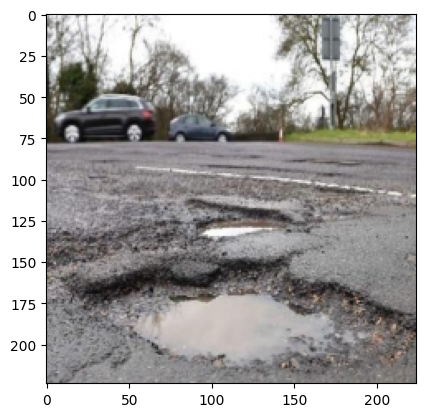

In [66]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

NameError: name 'pc' is not defined

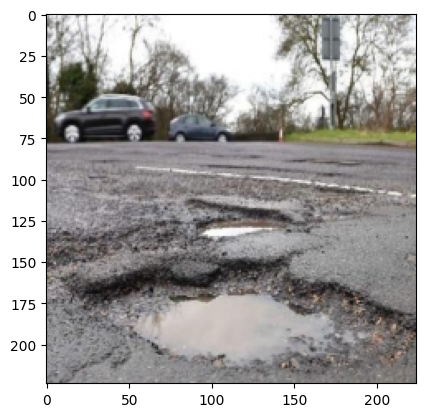

In [67]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]
    if batch_y[0]['labels'][i] == 1:
        color = 'red'

    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()


# **Defining the model**
fasterrcnn_resnet50_fpn_v2 5 epochs

In [70]:
# define model
#model = fasterrcnn_resnet50_fpn(pretrained=True)
model=fasterrcnn_resnet50_fpn_v2(pretrained=True)

/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /Users/ekaterina/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|████████████████████████████████████████| 167M/167M [00:21<00:00, 8.20MB/s]


In [71]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [72]:

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [73]:

# check model on one image
model.eval()
output = model(batch_x[5].view(1, 3, 224, 224))

In [74]:
output

[{'boxes': tensor([[126.5697,  77.7177, 217.7893, 197.4230],
          [ 48.1162,  91.8897, 224.0000, 185.5240],
          [ 56.8761,  41.1331, 139.5257, 129.5342],
          [ 40.4579,  39.4259, 143.4036, 215.4798],
          [122.9583,   0.0000, 204.9082,  25.1790],
          [ 69.3697,  80.2214, 152.5759, 162.8245],
          [ 59.0080,  53.5328, 221.0233, 101.1918],
          [ 85.2763,  22.9972, 224.0000, 210.2539],
          [100.9086, 159.4325, 180.4227, 221.8528],
          [ 45.9397, 148.2168, 120.8305, 216.7234],
          [149.8121, 186.7357, 218.6443, 223.6652],
          [  3.5086, 153.9942, 168.4519, 214.2245],
          [104.9087,  37.6035, 179.9169, 117.4510],
          [197.5532,   0.0000, 221.1341,  41.0541],
          [ 36.0400,  65.7443, 123.6839, 158.0985],
          [ 99.7038,  48.1363, 125.1550, 103.0454],
          [ 38.9153,   0.0000,  51.9223,   8.8430],
          [105.8313,  46.6092, 203.9669, 155.6402],
          [ 78.8912, 150.1102, 124.6624, 192.9745],
   

In [10]:
#GPU if avilable
model = model.to(device)

NameError: name 'model' is not defined

In [76]:
# define optimization 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [77]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU if available
        batch_x = list(image.to(device) for image in batch_x)
        batch_y = [{k: v.to(device) for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.11275940629489281 for classification and 0.1328585495843607 for regression 
Training loss for epoch 2 is 0.05303136776475345 for classification and 0.10091057945700253 for regression 
Training loss for epoch 3 is 0.03309234414687928 for classification and 0.07994814878877471 for regression 
Training loss for epoch 4 is 0.029818889005657503 for classification and 0.0754856185439755 for regression 
Training loss for epoch 5 is 0.023939693949240094 for classification and 0.0682836343479507 for regression 


In [ ]:
#model = fasterrcnn_resnet50_fpn(pretrained=True)
#Training loss for epoch 1 is 0.11784416187335463 for classification and 0.15760746177505044 for regression 
#Training loss for epoch 2 is 0.07940252436434521 for classification and 0.1309680354069261 for regression 
#Training loss for epoch 3 is 0.06739366394193734 for classification and 0.11650033566881629 for regression 

#model=fasterrcnn_resnet50_fpn_v2(pretrained=True)
#Training loss for epoch 1 is 0.11275940629489281 for classification and 0.1328585495843607 for regression 
#Training loss for epoch 2 is 0.05303136776475345 for classification and 0.10091057945700253 for regression 
#Training loss for epoch 3 is 0.03309234414687928 for classification and 0.07994814878877471 for regression 
#Training loss for epoch 4 is 0.029818889005657503 for classification and 0.0754856185439755 for regression 
#Training loss for epoch 5 is 0.023939693949240094 for classification and 0.0682836343479507 for regression 

**Model Evaluation**

In [6]:

import pickle
import joblib
#save model
#filename = "Completed_model3.joblib"
#joblib.dump(model, filename)
#load pre-trained model
#loaded_model = joblib.load(filename)
model=joblib.load('Completed_model3.joblib')
#first model 'Completed_model.joblib'
#second model 'Completed_model2.joblib'
#third model 'Completed_model3.joblib'

In [7]:
#GPU if avilable
model = model.to(device)

In [8]:
test_dataset = PotHoleDataset('test/images/', transforms=transform,train=False)

In [9]:
# defining data loader
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False
)

In [12]:
import torch
torch.cuda.is_available()

False

In [16]:
!pip install cudatoolkit


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [10]:
my_submission = pd.DataFrame()
model.eval()
for batch_test,names in data_loader_test:
  output = model(batch_test.to(device))
  #output = [{k: v.to("cpu") for k, v in t.items()} for t in output]
  output = [{k: v.to("cpu") for k, v in t.items()} for t in output]
  temp = pd.DataFrame()
  for i in range(len(output)):
    boxes = output[i]['boxes'].detach().numpy()
    scores = output[i]['scores'].detach().numpy()
    labels = output[i]['labels'].detach().numpy()
    scores = np.expand_dims(scores, axis=1)
    labels = np.expand_dims(labels, axis=1)
    batch_df = pd.DataFrame(np.hstack((boxes,scores,labels)),columns=['XMin','YMin','XMax','YMax','Conf','LabelName'])
    batch_df['ImageID'] = names[i]
    #img = cv2.imread('/content/test/images/'+names[i])
    img = cv2.imread('test/images/'+names[i])
    h,w = img.shape[:2]
    batch_df['LabelName'] = 'pothole'
    batch_df['XMax'] = batch_df['XMax']/224 * w
    batch_df['XMin'] = batch_df['XMin']/224 * w
    batch_df['YMax'] = batch_df['YMax']/224 * h
    batch_df['YMin'] = batch_df['YMin']/224 * h
    batch_df['XMax'] = batch_df['XMax'].astype(int)
    batch_df['XMin'] = batch_df['XMin'].astype(int)
    batch_df['YMax'] = batch_df['YMax'].astype(int)
    batch_df['YMin'] = batch_df['YMin'].astype(int)
    temp = pd.concat([batch_df,temp])
  my_submission = pd.concat([my_submission,temp])

In [11]:
my_submission.to_csv('first_solution3.csv',index=False)